In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# notebooks/2_hidden_state_analysis.ipynb
import sys
import os

# 设置项目根目录为当前目录
project_root = os.path.abspath("..")
sys.path.append(project_root)

from src.data_utils import load_datasets, build_few_shot_prompts
from src.model_utils import load_model_and_tokenizer, collect_hidden_states
from src.visualization import plot_tsne_layers, plot_selected_layers

In [3]:
MODEL_NAME = "Llama-2-13b-hf"
MODELS_ROOT_PATH = "/mnt/data102_d2/huggingface/models"

In [4]:
# Load datasets
data_dir = '../data/processed'
datasets = load_datasets(data_dir, split='train')

Loaded wikitext2 dataset from train split, shape: (36718, 6)
Loaded hellaswag dataset from train split, shape: (39905, 6)
Loaded gsm8k dataset from train split, shape: (7473, 6)
Loaded winogrande dataset from train split, shape: (2558, 6)
Loaded boolq dataset from train split, shape: (9427, 6)
Loaded obqa dataset from train split, shape: (4957, 6)
Loaded piqa dataset from train split, shape: (16113, 6)
Loaded ai2_arc dataset from train split, shape: (1119, 6)


In [5]:
test_list = ['gsm8k', 'hellaswag', 'winogrande', 'piqa', 'ai2_arc', 'obqa', 'boolq']

In [6]:
datasets = {k: v for k, v in datasets.items() if k in test_list}

In [7]:
shot_inputs, task_types = build_few_shot_prompts(
    datasets,
    min_shot=1,
    max_shot=3,
    seed=44,
    sample_size=200,
    use_corpus=True
)

In [8]:
print(shot_inputs[0])

A group of boys are shown running down a gym holding hands and putting their hands into the air. a woman speaks to the boys while they drink some water and transitions into them playing a game and scoring a goal.


In [9]:
# Load the pre-trained model and tokenizer
model_name = MODEL_NAME
models_root_path = MODELS_ROOT_PATH

# 拼接完整的存储路径
model_path = os.path.join(models_root_path, model_name)

In [10]:
model, tokenizer = load_model_and_tokenizer(model_path)

/mnt/data131/hanyu/envs/llm_env/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
hidden_states_list, types = collect_hidden_states(shot_inputs, task_types, model, tokenizer)

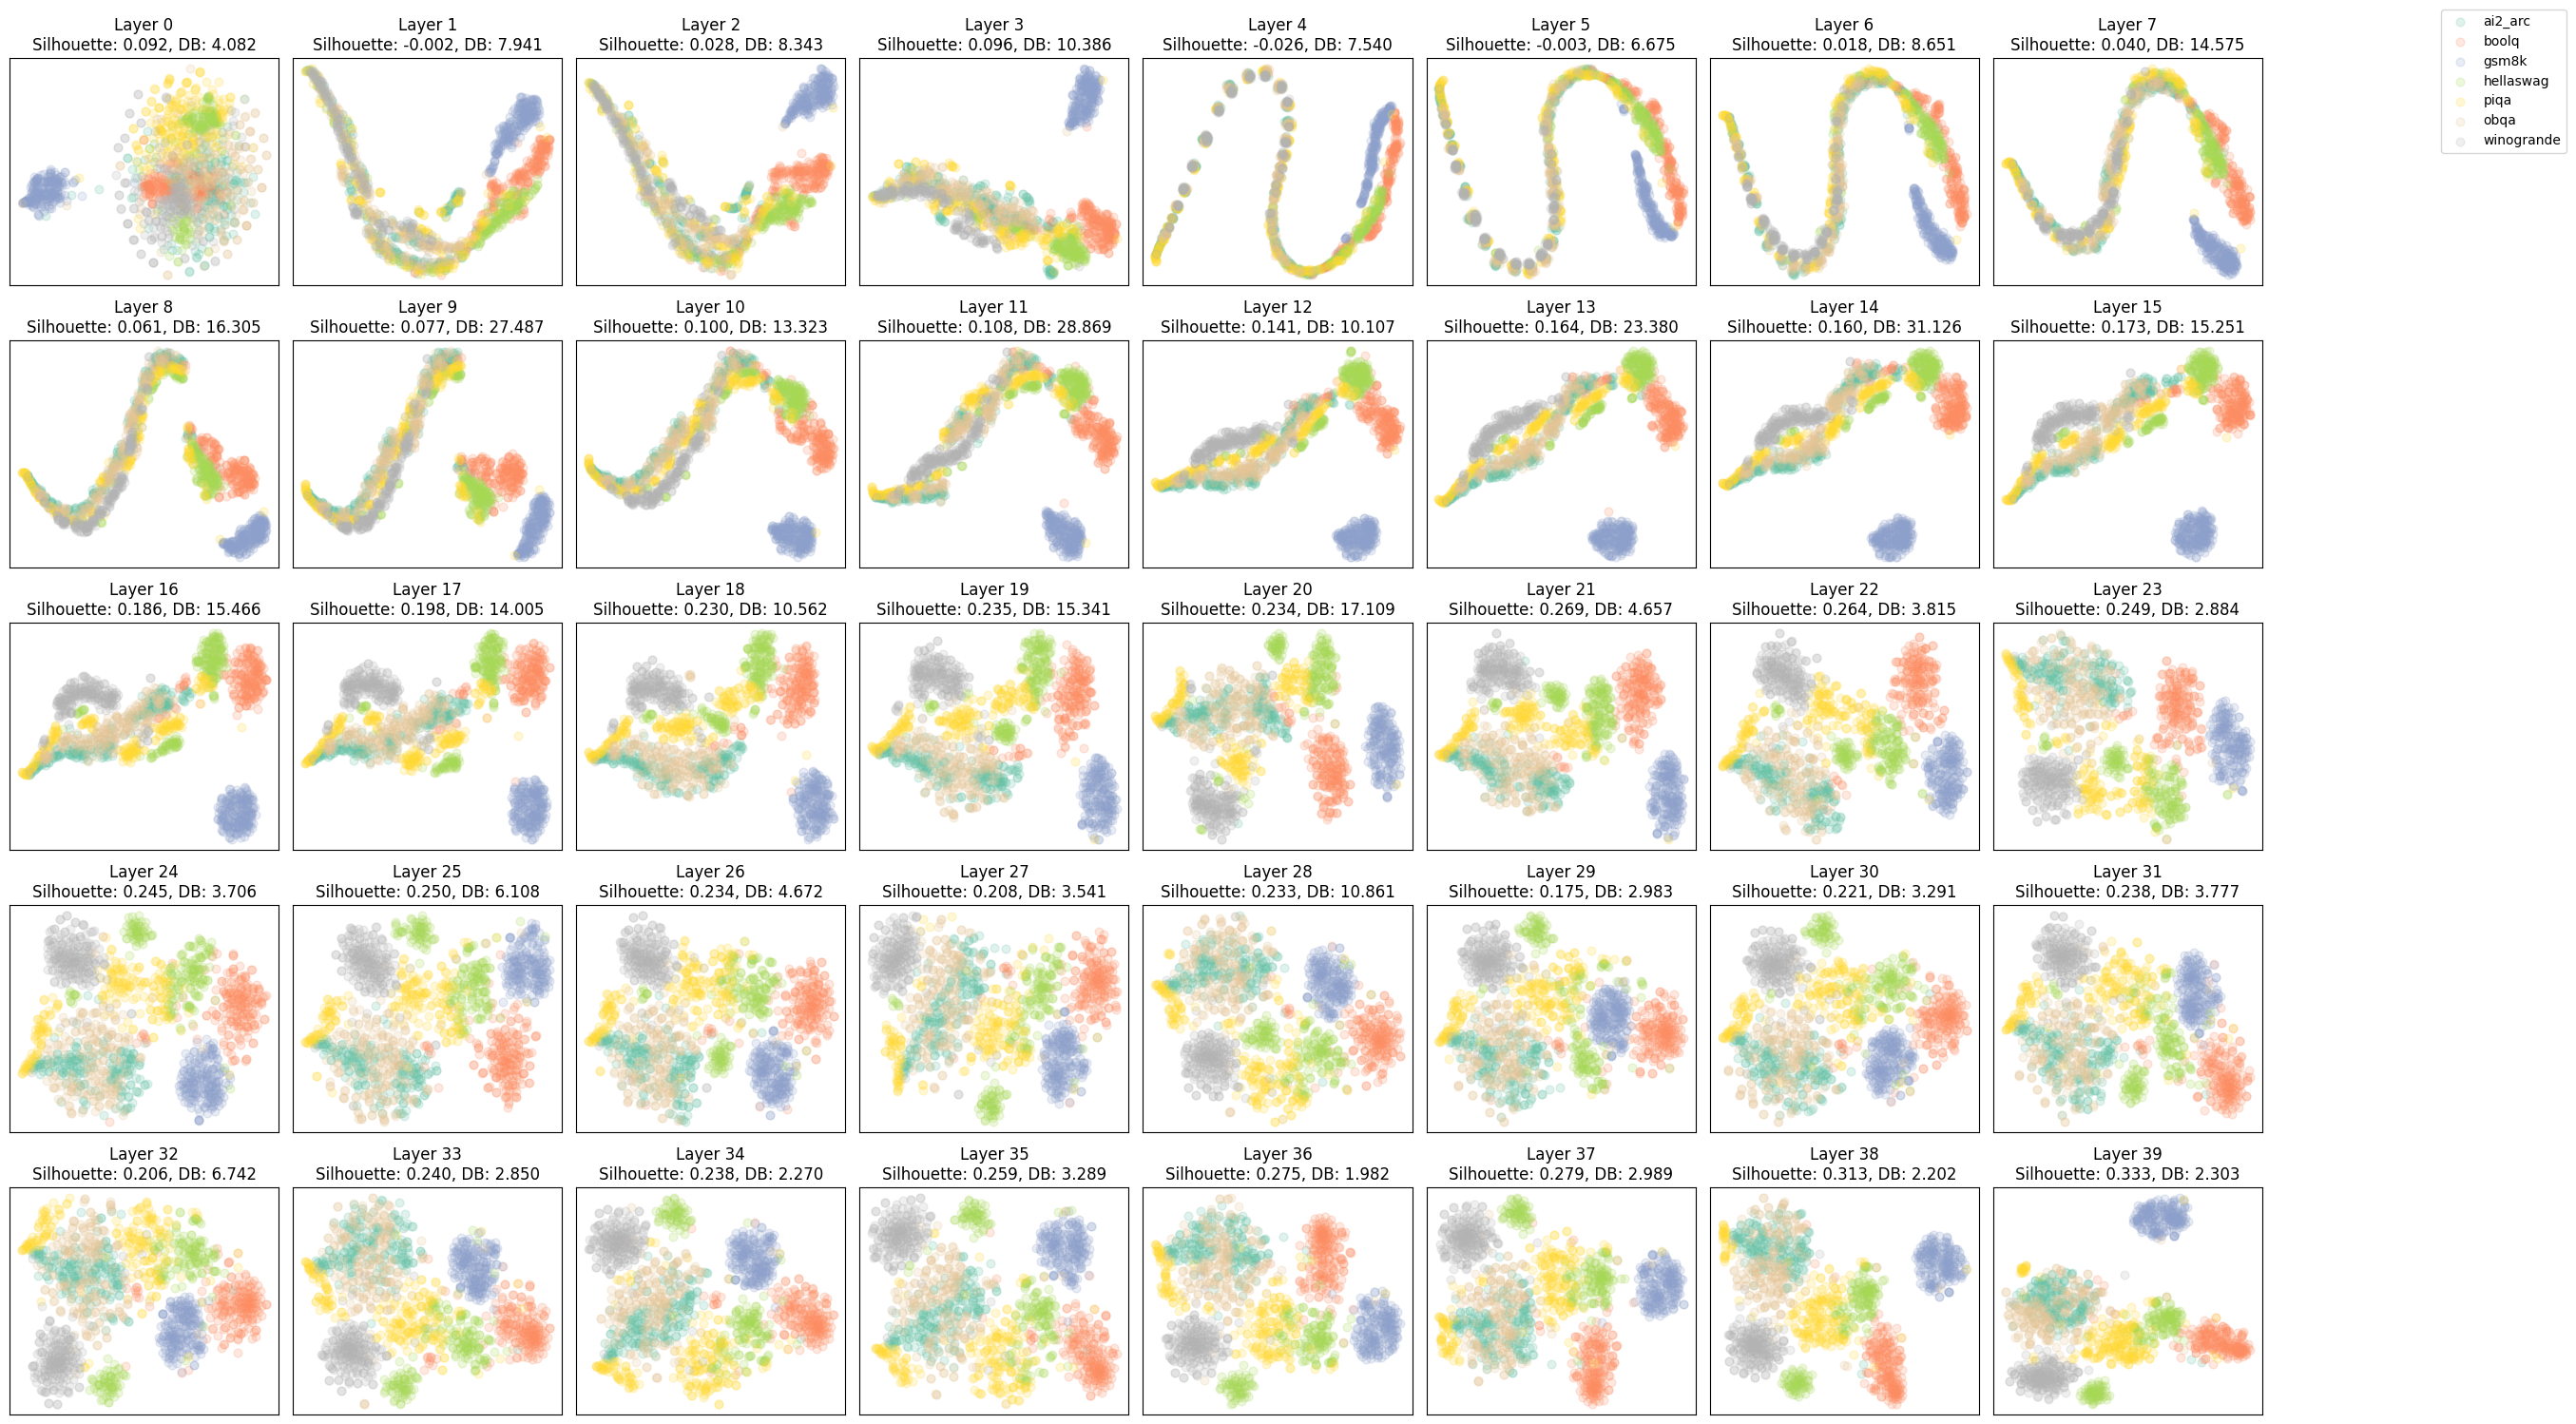

In [ ]:
# 绘制所有层的 t-SNE 可视化，选择二维或三维
plot_tsne_layers(hidden_states_list, types, perplexity=50, n_components=2)

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from mpl_toolkits.mplot3d import Axes3D  # 用于3D绘图
from typing import Dict, List
import seaborn as sns


In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

def plot_selected_layers(hidden_states_list, labels, perplexity=50):
    """
    绘制选定层的 t-SNE 可视化。第一张为第0层，最后一张为最后一层，其他的10张均匀分布在中间层之间。
    所有的图都是2D t-SNE。
    """
    unique_labels = ['winogrande', 'hellaswag', 'piqa', 'gsm8k', 'ai2_arc', 'obqa', 'boolq']
    cmap = plt.cm.get_cmap('Set2', len(unique_labels))
    point_size = 150
    font_size = 20

    total_layers = len(hidden_states_list[0])
    
    # 中间层选择，排除第0层和最后一层
    middle_layers = np.linspace(1, total_layers - 2, 8, dtype=int)
    layers = [0] + list(middle_layers) + [total_layers - 1]  # 包括第0层和最后一层

    # 创建网格布局
    fig = plt.figure(figsize=(24, 8))  # Adjusted figure size for 2 rows and 5 columns
    rows = 2  # Two rows for better layout
    cols = 5  # Five columns

    # 标签编码
    le = LabelEncoder()
    labels_encoded = le.fit_transform(labels)

    # 绘制每一层的t-SNE
    for idx, layer_idx in enumerate(layers):
        ax = fig.add_subplot(rows, cols, idx + 1)
        ax.set_facecolor('#f9f9f9')

        # 提取指定层的隐藏状态
        hidden_states_layer = [h[layer_idx] for h in hidden_states_list]
        hidden_states_array = np.array(hidden_states_layer)

        if hidden_states_array.ndim == 2:
            tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
            hidden_states_tsne = tsne.fit_transform(hidden_states_array)
            for j, label in enumerate(unique_labels):
                idx = [k for k, l in enumerate(labels) if l == label]
                ax.scatter(hidden_states_tsne[idx, 0], hidden_states_tsne[idx, 1],
                           label=label, color=cmap(j), s=point_size, alpha=0.1)
            ax.set_title(f'Layer {layer_idx}', fontsize=font_size)
            ax.tick_params(axis='both', which='major', labelsize=font_size - 2)
            ax.grid(True, linestyle='--', linewidth=0.5, color='lightgrey')
        else:
            print(f"Layer {layer_idx} has unexpected shape.")

        # 移除外边框
        for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

    # 创建一个单独的subplot用来显示图例
    ax_legend = fig.add_subplot(rows, cols, 5)  # 选择最右边的位置作为图例
    ax_legend.axis('off')  # 关闭坐标轴

    # 绘制图例
    handles = []
    for j, label in enumerate(unique_labels):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(j), markersize=10, label=label))

    ax_legend.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.05, 1.05), fontsize=font_size)

    # 调整子图间的间距
    plt.subplots_adjust(hspace=0.3, wspace=0.2)  # Adjusted space between subplots

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3015369/319675224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set2', len(unique_labels))


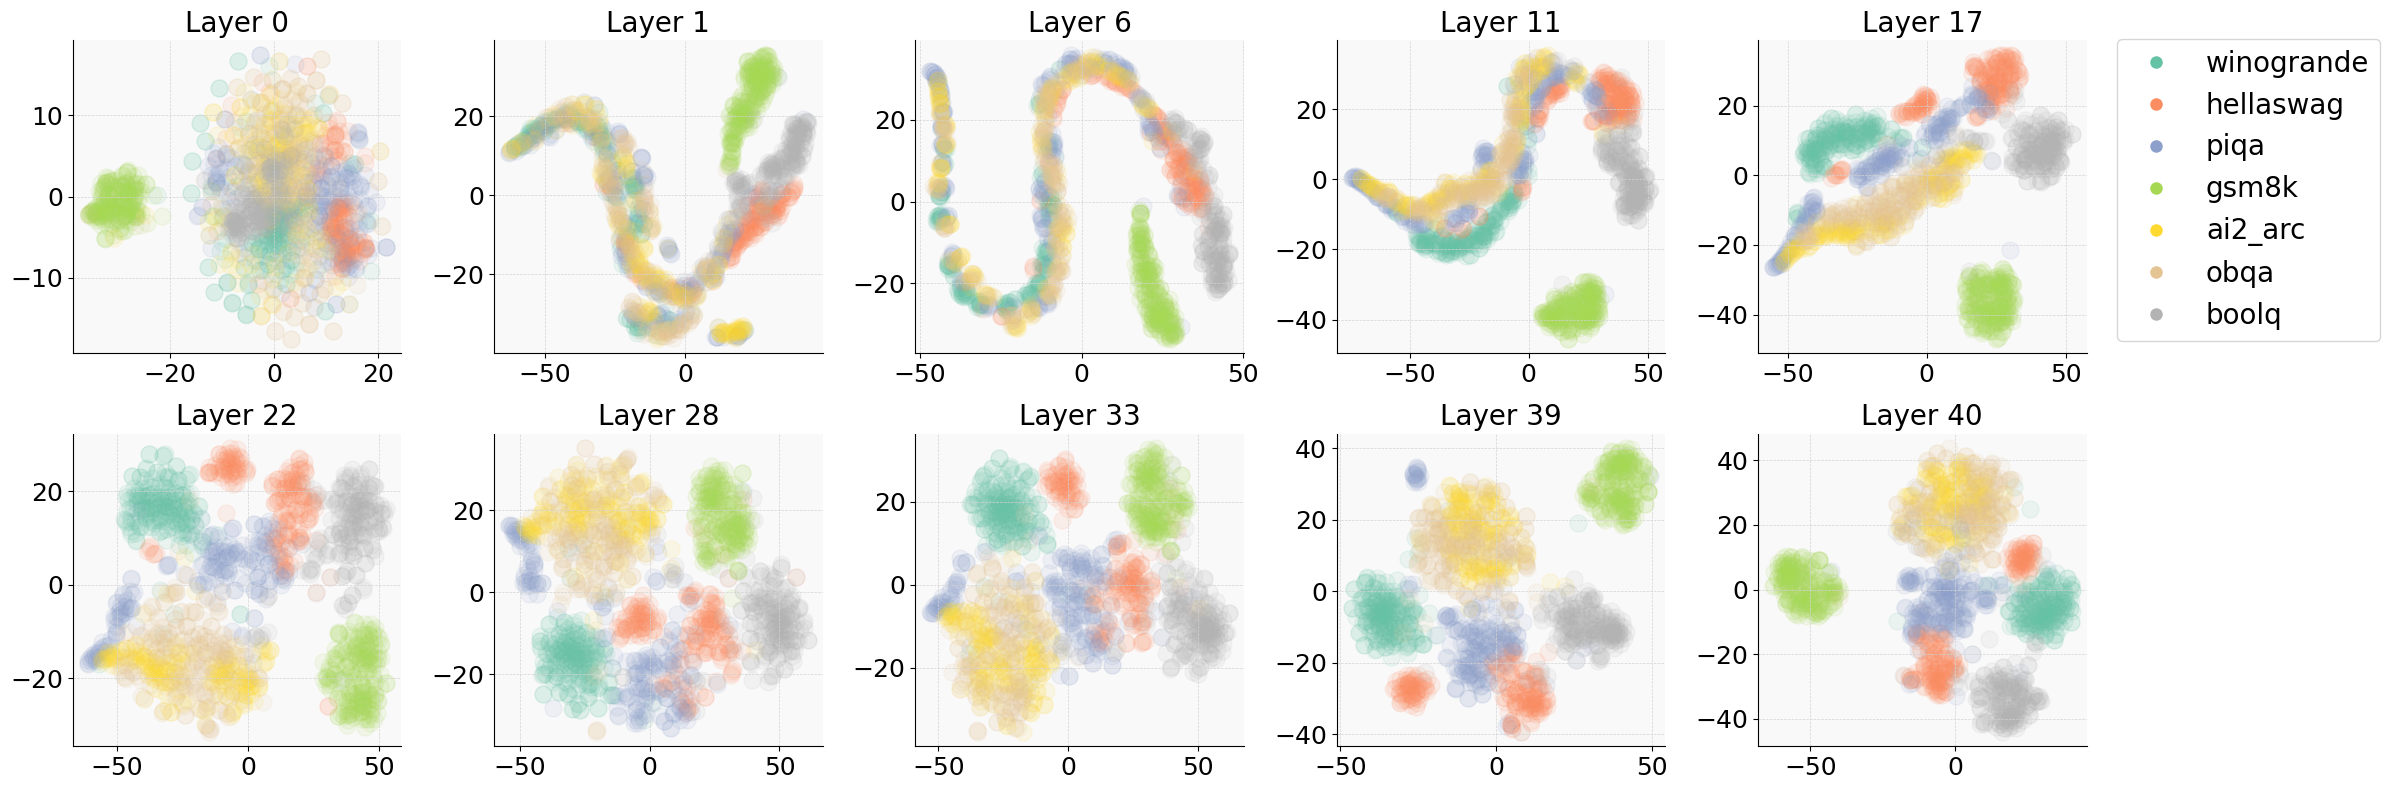

In [33]:
plot_selected_layers(hidden_states_list, types, perplexity=30)